In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

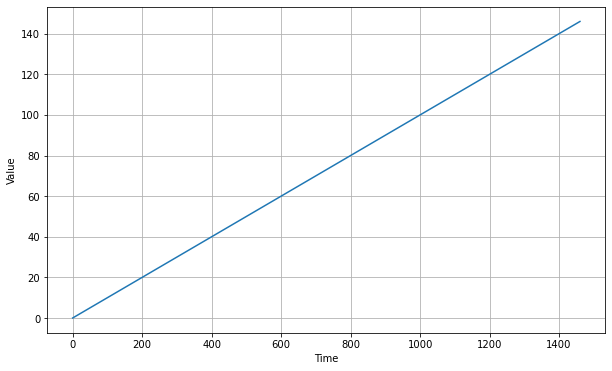

In [4]:
time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

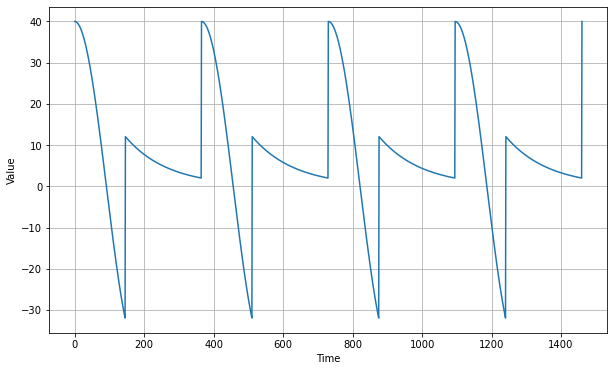

In [6]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

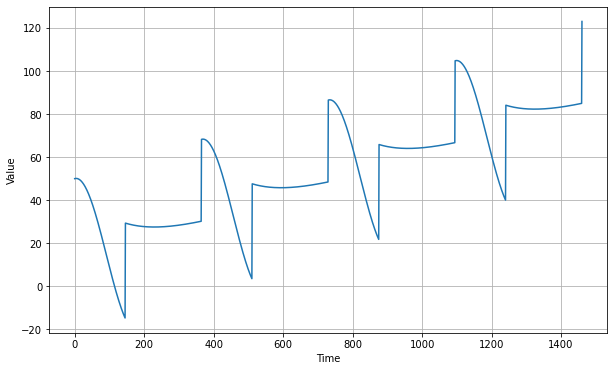

In [7]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [8]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

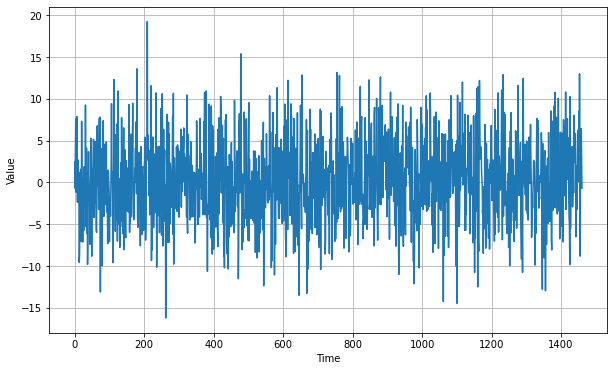

In [9]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

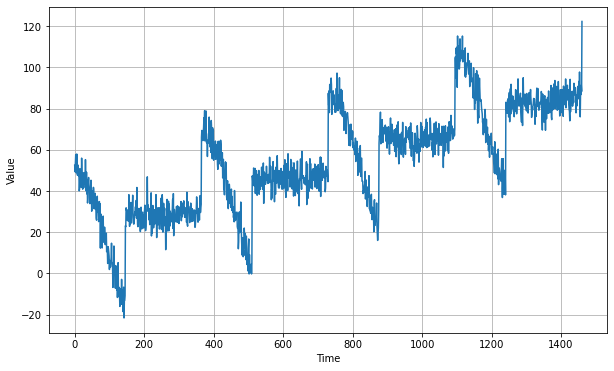

In [10]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [11]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [12]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(time) + 50)
    ar[:50] = 100
    for step in range(50, len(time) + 50):
        ar[step] += φ1 * ar[step - 50]
        ar[step] += φ2 * ar[step - 33]
    return ar[50:] * amplitude

In [13]:
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)
    φ = 0.8
    ar = rnd.randn(len(time) + 1)
    for step in range(1, len(time) + 1):
        ar[step] += φ * ar[step - 1]
    return ar[1:] * amplitude

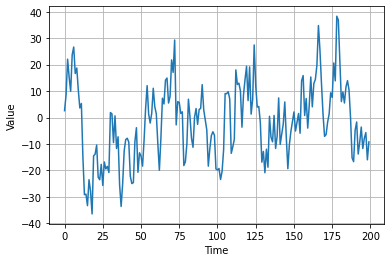

In [14]:
series = autocorrelation(time, 10, seed=42)
plot_series(time[:200], series[:200])
plt.show()

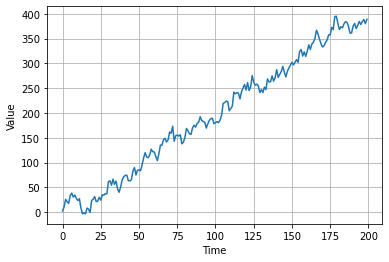

In [15]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

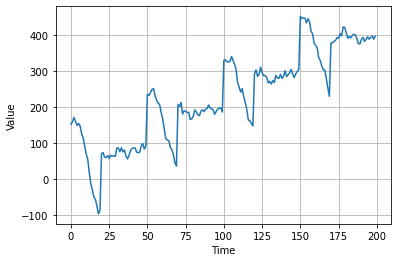

In [16]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

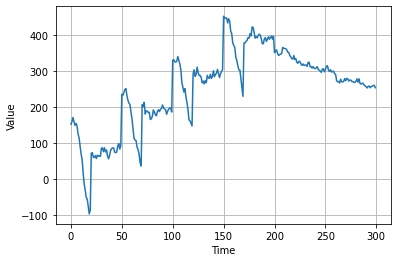

In [17]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [18]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series

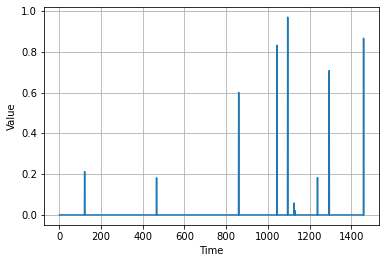

In [19]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [20]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
                ar[step] += φ * ar[step - lag]
    return ar

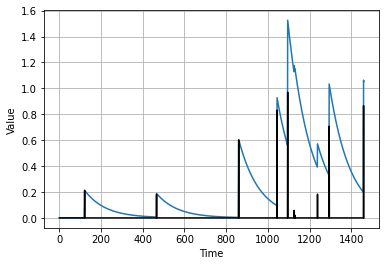

In [21]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

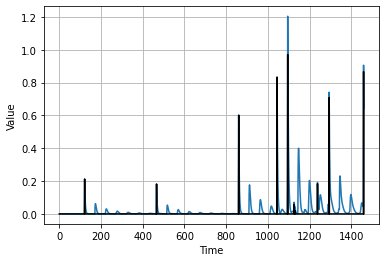

In [22]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

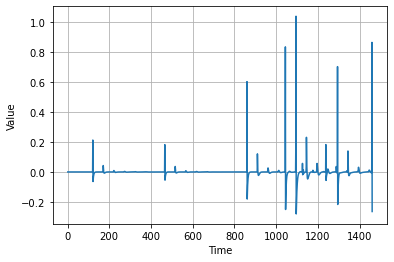

In [23]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

/home/mkim/anaconda3/envs/deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

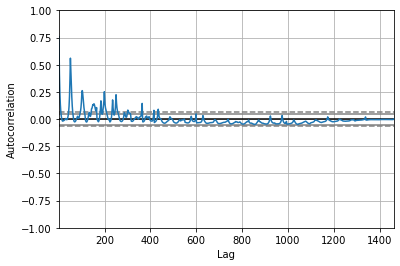

In [24]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [31]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1461
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.354
Date:                Wed, 03 Nov 2021   AIC                          -4434.708
Time:                        09:55:58   BIC                          -4402.991
Sample:                             0   HQIC                         -4422.876
                               - 1461                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1235      0.009    -13.155      0.000      -0.142      -0.105
ar.L2         -0.1256      0.016     -7.759      0.000      -0.157      -0.094
ar.L3         -0.1091      0.018     -6.160      0.0

In [32]:
!pip install gdown

In [33]:
!gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5

Downloading...
From: https://drive.google.com/uc?id=1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
To: /home/mkim/Documents/AI/Tensorflow/Course4/Sunspots.csv
100%|██████████████████████████████████████| 70.8k/70.8k [00:00<00:00, 1.58MB/s]


In [36]:
import pandas as pd

df = pd.read_csv('./Sunspots.csv', parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Freq: M, Name: Monthly Mean Total Sunspot Number, dtype: float64

<AxesSubplot:xlabel='Date'>

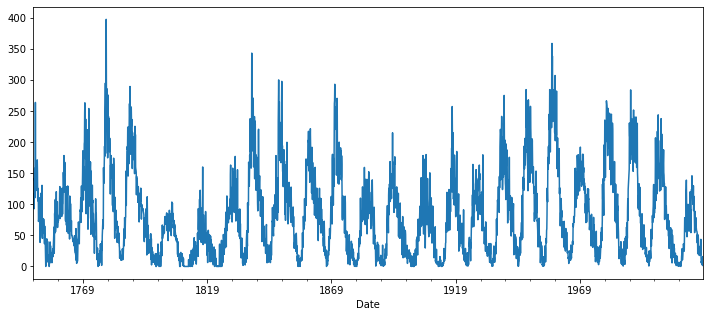

In [37]:
series.plot(figsize=(12, 5))

<AxesSubplot:xlabel='Date'>

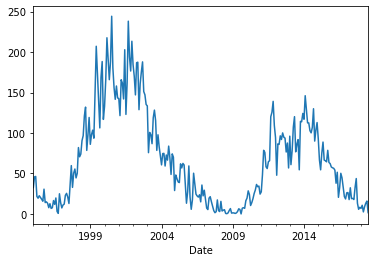

In [38]:
series["1995-01-01":].plot()

(0.0, 100.0, -50.0, 50.0)

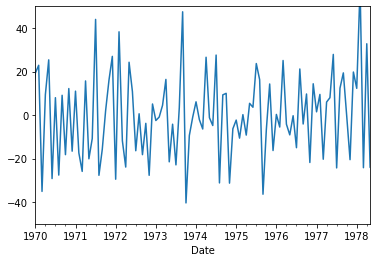

In [39]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

/home/mkim/anaconda3/envs/deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

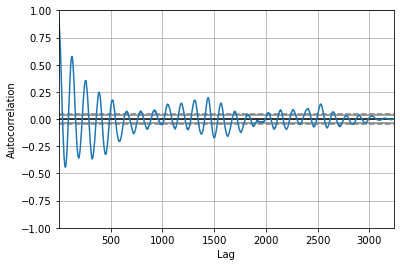

In [40]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

/home/mkim/anaconda3/envs/deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

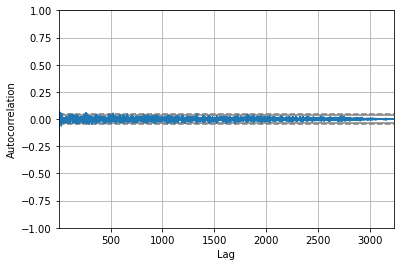

In [41]:
autocorrelation_plot(series.diff(1)[1:])

/home/mkim/anaconda3/envs/deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


(0.0, 500.0, -0.1, 0.1)

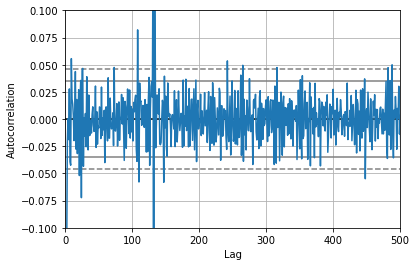

In [42]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

/home/mkim/anaconda3/envs/deeplearning/lib/python3.8/site-packages/pandas/plotting/_matplotlib/misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


(0.0, 50.0, -0.1, 0.1)

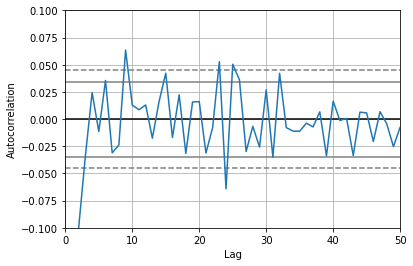

In [43]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [44]:
[series.autocorr(lag) for lag in range(1, 50)]

[0.9173241872367174,
 0.8847544206843755,
 0.868599123137202,
 0.8579945644357173,
 0.8433856340533112,
 0.8306731729540908,
 0.8121138897370149,
 0.7986059878541056,
 0.7890399489112041,
 0.7689560950230403,
 0.7474788716472306,
 0.7238791854325145,
 0.6980482665379879,
 0.6751408790165827,
 0.6495670049994807,
 0.6170092179855494,
 0.5872028494447984,
 0.5537209387574675,
 0.5254318210710769,
 0.49453915657274083,
 0.4609225001523783,
 0.4325062022560218,
 0.4054329883610248,
 0.36959289593532285,
 0.3443549899460771,
 0.3106967622634346,
 0.2711411693399097,
 0.23646964014948227,
 0.20297806535027266,
 0.17379537689762675,
 0.14010793836897956,
 0.11227445177460688,
 0.07751076852866026,
 0.044054957960606746,
 0.012510863120931944,
 -0.017282156504566333,
 -0.046433352357512225,
 -0.07440203532677167,
 -0.10339501296715731,
 -0.12680806162977237,
 -0.1530928264197593,
 -0.17906178224521474,
 -0.20506772757843425,
 -0.22530867957591932,
 -0.2466587000579558,
 -0.26904607854968615,
 

In [51]:
sunspots = pd.read_csv('./Sunspots.csv', sep=',', delimiter=None, header='infer', names=None, 
            index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, 
            dtype=None, engine=None, converters=None, true_values=None, false_values=None, 
            skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, 
            keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, 
            infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, 
            chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', 
            quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, 
            error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, 
            low_memory=True, memory_map=False, float_precision=None)

In [52]:
sunspots

Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0              0  1749-01-31                               96.7
1              1  1749-02-28                              104.3
2              2  1749-03-31                              116.7
3              3  1749-04-30                               92.8
4              4  1749-05-31                              141.7
...          ...         ...                                ...
3230        3230  2018-03-31                                2.5
3231        3231  2018-04-30                                8.9
3232        3232  2018-05-31                               13.2
3233        3233  2018-06-30                               15.9
3234        3234  2018-07-31                                1.6

[3235 rows x 3 columns]

# Lab 2

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

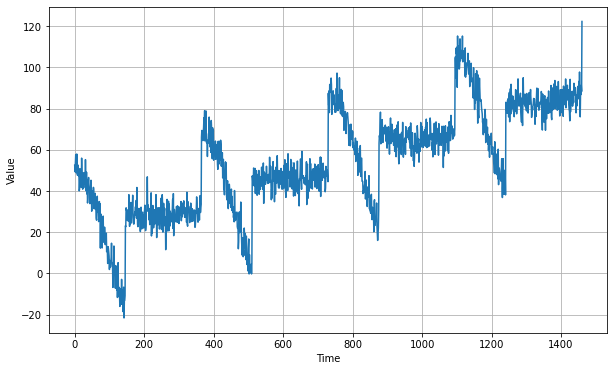

In [54]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

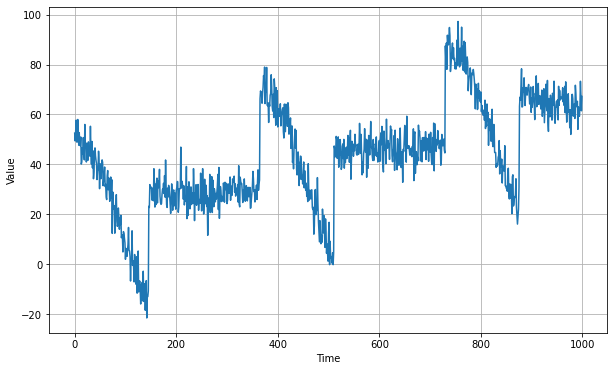

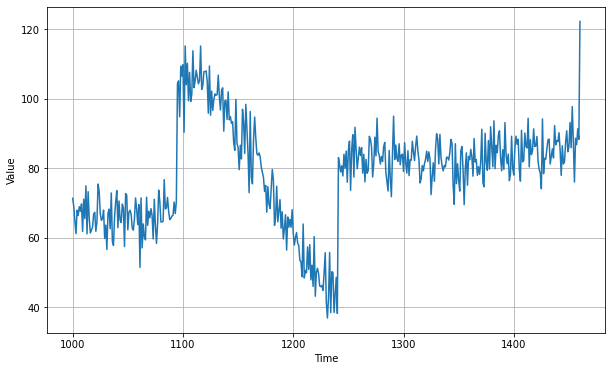

In [55]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

In [56]:
naive_forecast = series[split_time - 1:-1]

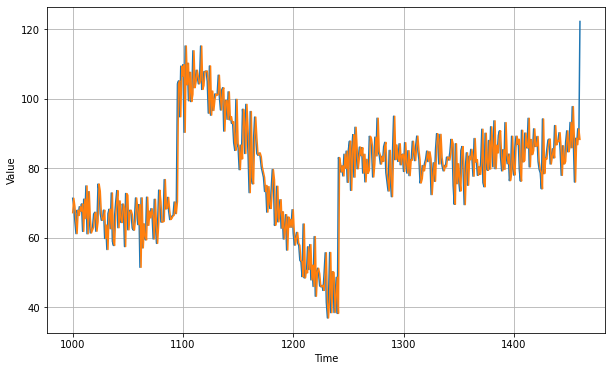

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

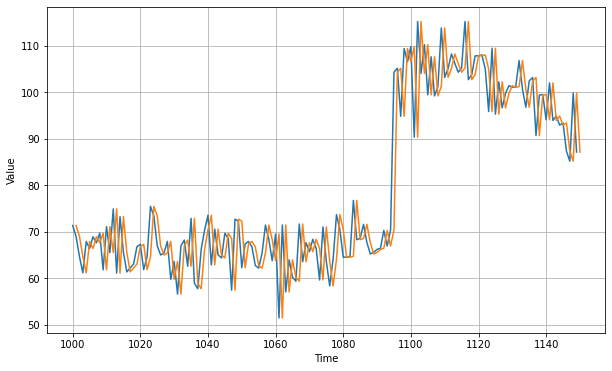

In [59]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [60]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.937908


In [61]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

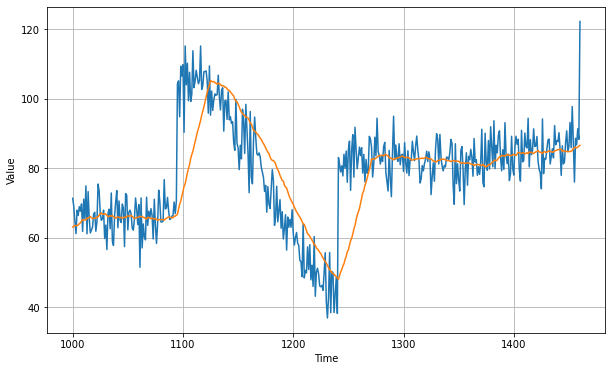

In [62]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [63]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.674576
7.142419


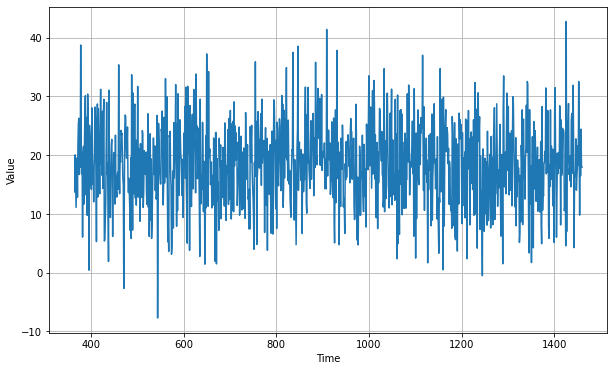

In [64]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

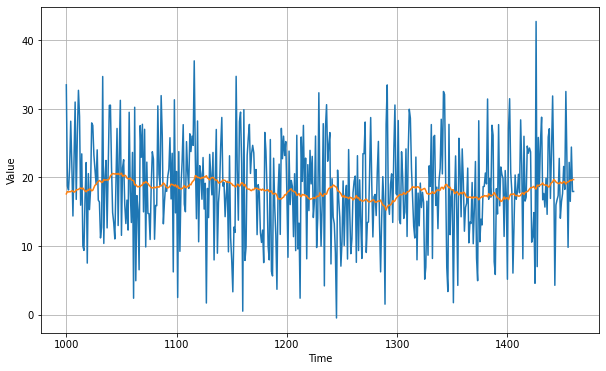

In [65]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

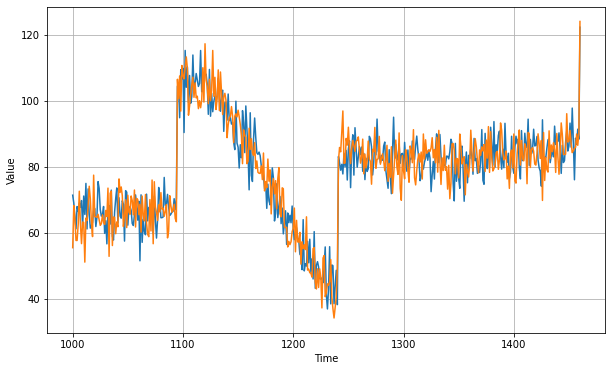

In [66]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [67]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

52.973663
5.839311


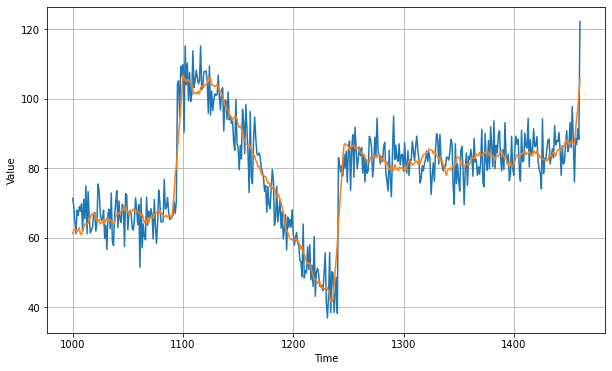

In [68]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [69]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

33.452263
4.569442
